In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 31.8 MB/s eta 0:00:00


**carte avec l'image du barrage 9 avril**

In [ ]:
import numpy as np
import folium
import rasterio

# Ouvrir le fichier COG et lire les bandes RGB (Band 2, Band 3 et Band 4 pour Sentinel-2)
with rasterio.open("/content/drive/MyDrive/cog/Barrage9Avril2024_cog.tif") as src:
    # Vérifier le CRS pour s'assurer que la référence spatiale est correcte
    crs = src.crs
    print(f"CRS de l'image: {crs}")

    # Obtenir les limites de l'image pour centrer la carte
    bounds = src.bounds
    print(f"Limites de l'image: {bounds}")

    # Lire les bandes Rouge (Band 4), Vert (Band 3), et Bleu (Band 2)
    red_band = src.read(4)  # Bande 4 - Rouge
    green_band = src.read(3)  # Bande 3 - Vert
    blue_band = src.read(2)  # Bande 2 - Bleu

    # Masquer les valeurs no-data pour chaque bande
    red_band = np.ma.masked_equal(red_band, src.nodata)
    green_band = np.ma.masked_equal(green_band, src.nodata)
    blue_band = np.ma.masked_equal(blue_band, src.nodata)

    # Normaliser les bandes (mise à l'échelle min-max)
    red_band_normalized = (red_band - red_band.min()) / (red_band.max() - red_band.min())
    green_band_normalized = (green_band - green_band.min()) / (green_band.max() - green_band.min())
    blue_band_normalized = (blue_band - blue_band.min()) / (blue_band.max() - blue_band.min())

    # Augmenter la luminosité en multipliant chaque bande par un facteur plus élevé
    brightness_factor = 3.0  # Augmenter la luminosité avec un facteur de 3.0
    red_band_normalized = np.clip(red_band_normalized * brightness_factor, 0, 1)
    green_band_normalized = np.clip(green_band_normalized * brightness_factor, 0, 1)
    blue_band_normalized = np.clip(blue_band_normalized * brightness_factor, 0, 1)

    # Empiler les bandes pour créer une image RGB (tableau 3D avec dimensions: hauteur x largeur x 3)
    rgb_image = np.dstack((red_band_normalized, green_band_normalized, blue_band_normalized))

    # Convertir MaskedArray en tableau NumPy classique (pour résoudre le problème de sérialisation JSON)
    rgb_image = rgb_image.filled(0)  # Remplacer les valeurs masquées par 0 (ou une autre valeur)

    # Initialiser une carte Folium centrée sur les limites de l'image
    map_center = [(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2]
    m = folium.Map(location=map_center, zoom_start=12, control_scale=True)

    # Ajouter l'image RGB comme un overlay à la carte avec une opacité de 1.0 pour plus d'opacité
    folium.raster_layers.ImageOverlay(
        image=rgb_image,
        bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
        opacity=1.0,  # Opacité maximale (100% opaque)
        name='Image RGB'
    ).add_to(m)

    # Ajouter un contrôle des couches et afficher la carte
    folium.LayerControl().add_to(m)
    m.save("map_with_rgb_and_brightness_high_v2.html")  # Sauvegarder la carte en HTML pour la visualiser dans un navigateur
    m  # Afficher la carte dans Jupyter

CRS de l'image: EPSG:4326
Limites de l'image: BoundingBox(left=-5.850817276998855, bottom=35.4865079946871, right=-5.725771789449418, top=35.590532904588144)


**carte avec les 2 images cog**


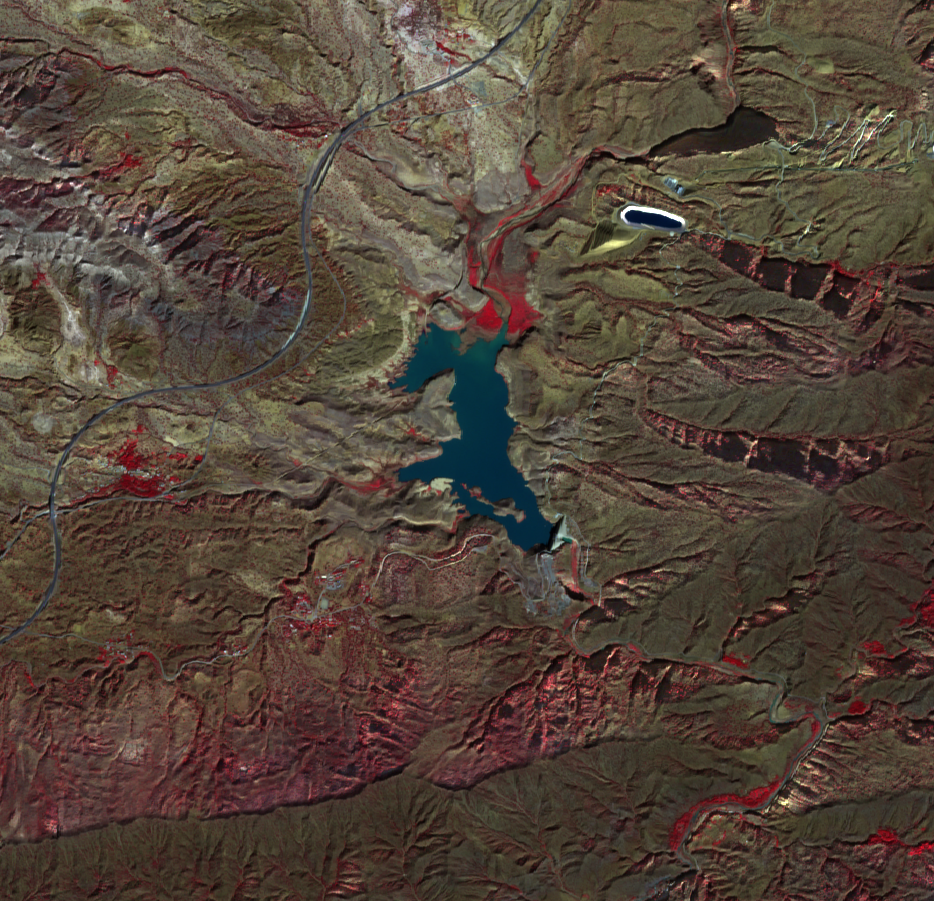
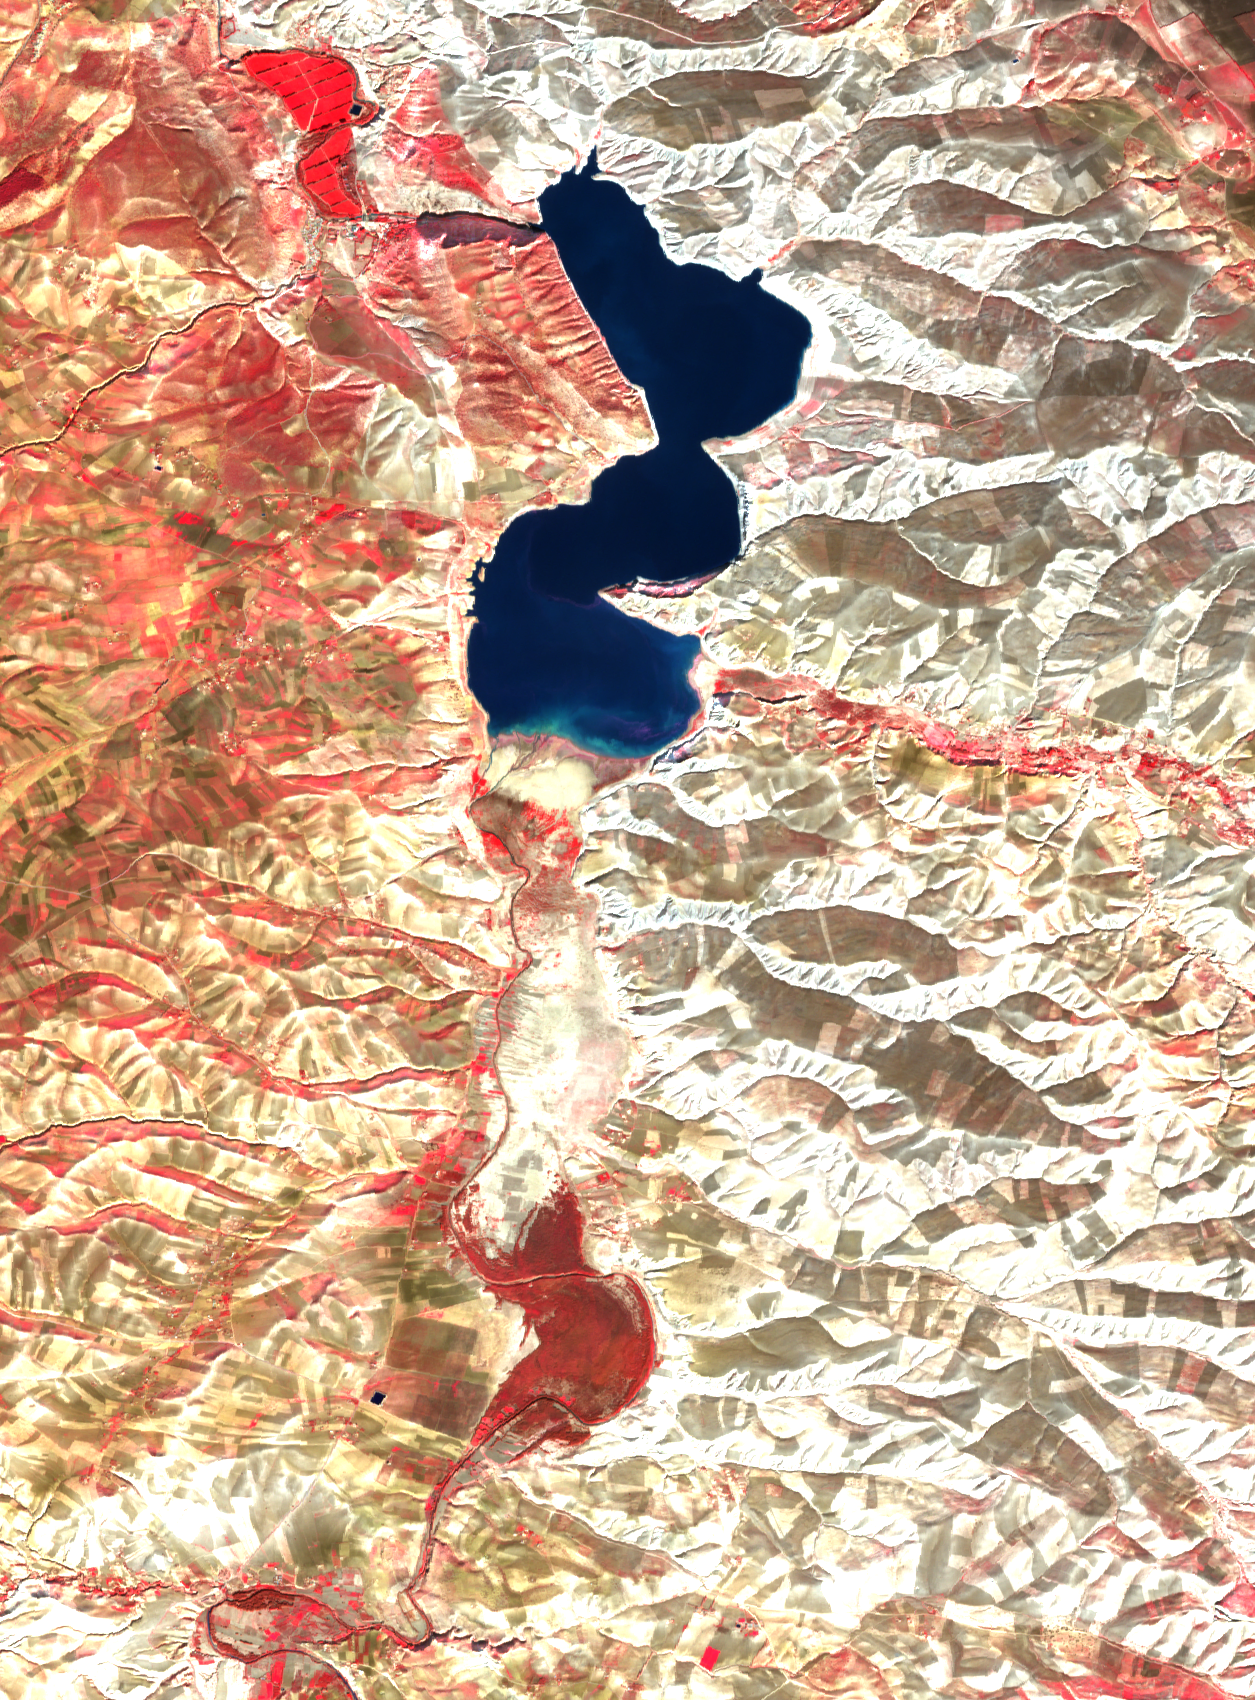

In [ ]:
import numpy as np
import folium
import rasterio

def read_rgb_image(image_path, brightness_factor=1.0):
    """
    Lit les bandes RGB d'une image raster, les normalise et ajuste la luminosité.
    """
    with rasterio.open(image_path) as src:
        # Lire les bandes : Rouge (4), Vert (3), Bleu (2)
        red_band = src.read(4)
        green_band = src.read(3)
        blue_band = src.read(2)

        # Masquer les valeurs no-data
        red_band = np.ma.masked_equal(red_band, src.nodata)
        green_band = np.ma.masked_equal(green_band, src.nodata)
        blue_band = np.ma.masked_equal(blue_band, src.nodata)

        # Normaliser les bandes
        red_band = (red_band - red_band.min()) / (red_band.max() - red_band.min())
        green_band = (green_band - green_band.min()) / (green_band.max() - green_band.min())
        blue_band = (blue_band - blue_band.min()) / (blue_band.max() - blue_band.min())

        # Ajuster la luminosité
        red_band = np.clip(red_band * brightness_factor, 0, 1)
        green_band = np.clip(green_band * brightness_factor, 0, 1)
        blue_band = np.clip(blue_band * brightness_factor, 0, 1)

        # Créer une image RGB en empilant les bandes
        rgb_image = np.dstack((red_band, green_band, blue_band))

        # Convertir MaskedArray en tableau NumPy classique
        rgb_image = rgb_image.filled(0) # Remplacer les valeurs masquées par 0

        return rgb_image, src.bounds

# Chemins des deux fichiers raster
image_path_1 = "/content/drive/MyDrive/cog/BarrageAbdelmoumen2024_cog.tif"
image_path_2 = "/content/drive/MyDrive/cog/BarrageD'ElKansera2024_cog.tif"

# Lire et préparer les deux images
rgb_image_1, bounds_1 = read_rgb_image(image_path_1, brightness_factor=3.0)
rgb_image_2, bounds_2 = read_rgb_image(image_path_2, brightness_factor=3.0)

# Initialiser la carte centrée sur le Maroc
map_center = [31.7917, -7.0926]  # Latitude et longitude du Maroc
m = folium.Map(location=map_center, zoom_start=6, control_scale=True)

# Ajouter la première image (Barrage Abdelmoumen)
folium.raster_layers.ImageOverlay(
    image=rgb_image_1,
    bounds=[[bounds_1[1], bounds_1[0]], [bounds_1[3], bounds_1[2]]],
    opacity=0.7,
    name='Barrage Abdelmoumen'
).add_to(m)

# Ajouter la deuxième image (Barrage El Kansera)
folium.raster_layers.ImageOverlay(
    image=rgb_image_2,
    bounds=[[bounds_2[1], bounds_2[0]], [bounds_2[3], bounds_2[2]]],
    opacity=0.7,
    name='Barrage El Kansera'
).add_to(m)

# Ajouter les marqueurs pour les barrages
folium.Marker(
    location=[30.688643, -9.208464],  # Latitude et longitude approximatives du Barrage Abdelmoumen
    popup="Barrage Abdelmoumen",
    icon=folium.Icon(color="blue", icon="info-sign")
).add_to(m)

folium.Marker(
    location=[34.002056, -5.902608],  # Latitude et longitude approximatives du Barrage El Kansera
    popup="Barrage El Kansera",
    icon=folium.Icon(color="green", icon="info-sign")
).add_to(m)

# Ajouter un contrôle des couches
folium.LayerControl().add_to(m)

# Sauvegarder la carte en HTML
m.save("map_with_two_images_and_markers.html")
m  # Afficher la carte dans Jupyter
